In [5]:
#%%capture output
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()
#%%output.show()

In [6]:
# UMAP of SS2 endoderm on YS broad_cell.labels x2 (one coloured, one with 10x in grey)

In [7]:
#Introduce variables

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/combined_ys_fliv_data_090321/"

#name of first object
data1 = "_SC_train"
Object1 = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A1.210312_lvl5_ys_for_yolk.h5ad'
#provide cateorical to join between datasets
cat1 = "cell_labels"

#name of second object
data2 = "_predicted_SS2"
Object2 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/SS2/YS_ss2.h5ad"
#provide cateorical to join between datasets
cat2 = "lane_id"

# Required: LR Model Options
penalty='l2' 
sparcity=0.2

# Optional: Batch correction options (this is for correction of eventual combined dataset for data1 and data2)
# If you do not have a batch variable for either data1 or data2, please add a "filler" column in the relevent adata.obs
# for the purposes of batch_correction and batch args below.
# e.g., adata.obs["whatever"] = "something"; batch="whatever"
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ['orig_ident', 'fetal_ids'] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2

# Optional: miscellaneous Options.   
subsample_train = False # Samples the training data to the smallest fraction (highly dependent on resolution of input celltype categorical). This corrects for proportional differences between celltype labels of interest in the training data. E.g., training data has 50,000 B cells, 20,000 T cells and 100 HSCs. This function will subsample all training to 100 cells per cell type.  
train_x = 'X_pca' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' # "./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = True # Do you want to use adata.raw.X (recommended)

In [4]:
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata2 =  sc.read(Object2)

adata file paths detetcted, proceeding to load


In [5]:
adata2

AnnData object with n_obs × n_vars = 143 × 19734
    obs: 'seq_source', 'lane_id', 'cell.labels'

In [6]:
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata = sc.read(Object1)
    adata2 =  sc.read(Object2)
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")
##
adata2.obs["fetal_ids"] = "SS2"

adata file paths detetcted, proceeding to load


KeyboardInterrupt: 

# 2 - Pre-processing data

# Combine and pre-process data to match correlations across PCA

In [10]:
# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Combine and pre-process data to match correlations across PCA

# Module to detect shape mismatch and alternatively rebuild adata
if(use_raw==True):
    print('option detected to use raw data, proceeding to check if raw exists and if it matches data.X')
    if (hasattr(adata.raw, "X")):
        try: adata.X =  adata.raw.X  ; print('no mismatch in shape for adata detected')
        except: print("adata.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata.raw = adata
        
    if (hasattr(adata2.raw, "X")):
        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata2.raw = adata2
            
# Define intersecting genes between datasets
adata_genes = list(adata.var.index)
adata2_genes = list(adata2.var.index)
keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
adata_intersect1 = adata[:, keep_SC_genes]
adata = adata_intersect1
adata_intersect2 = adata2[:, keep_SC_genes]
adata2 = adata_intersect2

# Optional subsampling of training data to 
if(subsample_train == True):
    data = adata.obs
    data = data.sample(frac=1).groupby('corr_concat').head(min(adata.obs.groupby(cat1).size()))
    keep = data.index
    adata = adata[adata.obs.index.isin(keep)]

# Create a common batch column and do simple sanity check for batch variables
if not((batch_correction == "False") and (len(batch)>1)):
    print("Batch correction option detected, proceeding to format batch variables")
    batch_var = "lr_batch"
    adata.obs["lr_batch"] = adata.obs[batch[0]]
    adata2.obs["lr_batch"] = adata2.obs[batch[1]]
else: raise TypeError("Batch correction option detected but requires at least one categorical for each dataset!")

# Create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata.obs = adata.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
concat = adata2.concatenate(adata, join='inner',index_unique=None, batch_categories=None)
adata = concat[:]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
sc.pp.scale(adata, zero_center=False, max_value=None, copy=False)

# Optionally remove genes of known confounding effect from variable list
if not (Path(remove_effect_of_custom_gene_list).is_file()):
    print("Custom gene list option is not selected or path is not readbale, proceeding with no variable removal")
else: 
    print("Custom gene removal list detected, proceeding to remove intersect from variable genes")
    regress_list = pd.read_csv(remove_effect_of_custom_gene_list)
    regress_list = regress_list.iloc[:, 0]
    adata.var["highly_variable"][adata.var.index.isin(regress_list)] = "False"
    
# Now compute PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

# Batch correction options
# The script will test later which Harmony values we should use
if(batch_correction == "False"):
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)    
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata = adata_hm[:]
elif(batch_correction == "BBKNN"):
    print("Commencing BBKNN")
    sc.external.pp.bbknn(adata, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
    
print("adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!")

#adata_path = save_path + "A1.210312_combined_YS_matched_fliv.h5ad"
#adata.write(adata_path)

2021-03-18 17:02:17,138 - harmonypy - INFO - Iteration 1 of 10
2021-03-18 17:11:41,812 - harmonypy - INFO - Iteration 2 of 10
2021-03-18 17:20:50,810 - harmonypy - INFO - Iteration 3 of 10
2021-03-18 17:29:56,683 - harmonypy - INFO - Converged after 3 iterations
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:14)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!


In [12]:
#Compute UMAP
sc.tl.umap(adata)
adata_path = save_path + "A1.210312_combined_YS_SS2.h5ad"
adata.write(adata_path)

computing UMAP
Trying to set attribute `.uns` of view, copying.
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:11)
... storing 'seq_source' as categorical
... storing 'lane_id' as categorical
... storing 'cell.labels' as categorical
... storing 'fetal_ids' as categorical
... storing 'lr_batch' as categorical
... storing 'corr_concat' as categorical
... storing 'n_genes' as categorical
... storing 'orig_ident' as categorical
... storing 'percent_mito' as categorical
... storing 'sort_ids' as categorical
... storing 'tissue' as categorical
... storing 'lanes' as categorical
... storing 'stages' as categorical
... storing 'sample_type' as categorical
... storing 'gender' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'res_30' as categorical
... storing 'LouvainClustering' as categorical
... storing 'fullmeta' as categorical
... storing 'short_code' as categorical
... storing 'scrublet_score' as categorical
... storing 'scrublet_cluster_score

In [30]:
adata.obs[adata.obs['seq_source'].isin(['SS2'])].columns

Index(['seq_source', 'lane_id', 'cell.labels', 'fetal_ids', 'lr_batch',
       'corr_concat', 'n_genes', 'n_counts', 'orig_ident', 'percent_mito',
       'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender',
       'AnnatomicalPart', 'res_30', 'LouvainClustering', 'fullmeta',
       'short_code', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval',
       'oldanno', 'leiden', 'leiden_sub', 'Hep', 'oldanno_2', 'Component',
       'refined_cell_labels', 'predicted', 'cell_labels_back_050820',
       'subcluster_annotation_back_050820', 'refined_cell_label_back_050820',
       '160920_cell_labels', '160920_subclusters', '160920_broad_cell_labels',
       'broad_cell_label', '301020_microglia_assignment',
       'restricted_301020_microglia_assignment',
       'predicted_301020_microglia_assignment', 'lvl_1_cell.labels',
       'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'batch',
       'col'],
      dtype='object')

the obs value 'corr_concat' has more than 103 categories. Uniform 'grey' color will be used for all categories.


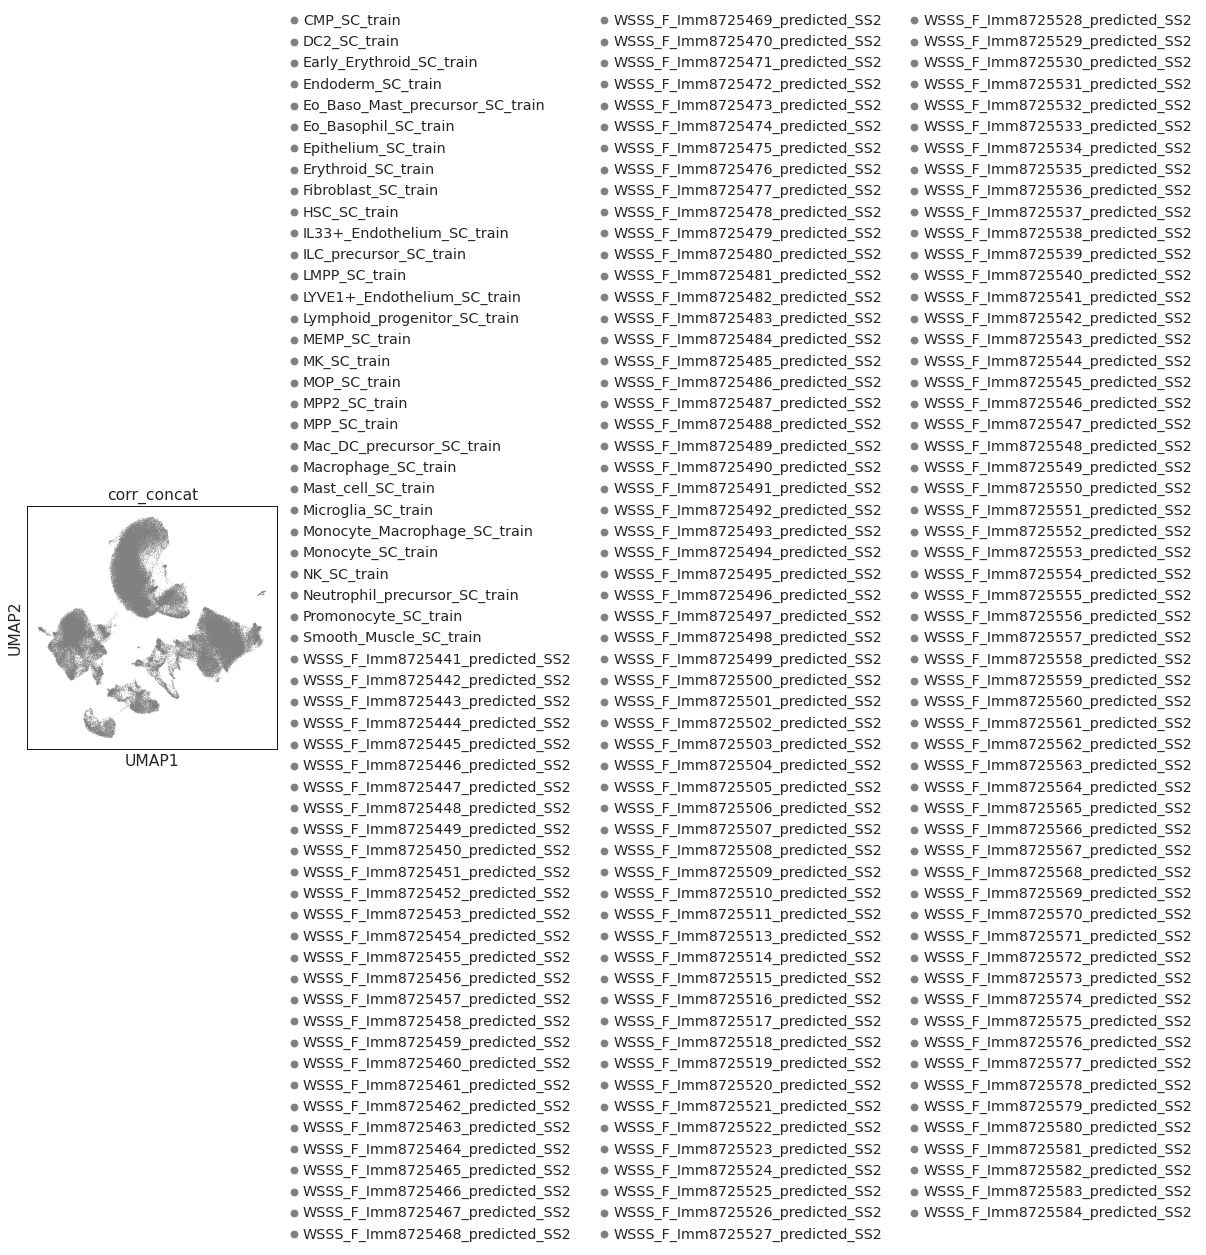

In [13]:
sc.pl.umap(adata,color = "corr_concat")

# Plot UMAP S2 overlay

In [121]:
# get previously predicted ss2 labels
adata_ss2 = sc.read('/nfs/team205/ig7/work_backups/backup_210303/data/projects/YS/YS_data/ys_ss2_cluster_assignment_predictions.h5ad')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [122]:
predicted_ss2_labels = adata_ss2.obs
#predicted_ss2_labels.to_csv("./predicted_ss2_labbels.csv")

In [123]:
list(predicted_ss2_labels["clus_prediction"].unique())

['Hepatoid_SC_train',
 'Erythroid_SC_train',
 'Angiogenic_SC_train',
 'Epithelial_SC_train',
 'Fibroblast_SC_train',
 'Megakaryocyte_SC_train',
 'Smooth_Muscle_SC_train']

In [124]:
adata = sc.read(save_path + "A1.210312_combined_YS_SS2.h5ad")

In [125]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype(str)
adata.obs['cell.labels'].loc[adata.obs.index.isin(list(predicted_ss2_labels.index))]= predicted_ss2_labels["clus_prediction"].astype(str)
#filter adata for any ss2 not in mapping
adata = adata[~adata.obs["cell.labels"].isin(["SS2"])]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Update to latest YS metadata

In [126]:
meta = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/A2_V7_YS_main_metadata_161121.csv',index_col = 0)

In [127]:
meta['corr_concat'] = meta['broad_cell.labels'].astype(str) + '_' + 'ys'
meta = meta.set_index('V5_old_indexes')
adata.obs.loc[adata.obs.index.isin(meta.index),'cell.labels'] = meta['broad_cell.labels']

In [128]:
ss2_index = list(adata.obs.index[adata.obs['seq_source'] == 'SS2'])
adata_index = list(adata.obs.index[adata.obs.index.isin(meta.index)])
adata_index.extend(ss2_index)
adata = adata[adata.obs.index.isin(adata_index)]

In [129]:
#Remove some outliers
remove = ["WSSS_F_Imm8725543","WSSS_F_Imm8725449","WSSS_F_Imm8725507","WSSS_F_Imm8725441","WSSS_F_Imm8725584","WSSS_F_Imm8725535"]
adata = adata[~adata.obs.index.isin(remove)]

In [130]:
adata.obs['cell.labels'].value_counts()

Erythroid                 51890
Macrophage                32681
Fibroblast                17523
Smooth_Muscle              5167
LYVE1+_Endothelium         4256
Endoderm                   2951
microglia                  1768
Epithelium                 1397
IL33+_Endothelium          1299
MK                          854
Lymphoid_progenitor         570
Early_Erythroid             482
DC2                         394
Monocyte                    363
Mac_DC_precursor            304
Eo_Basophil                 212
Mast_cell                   181
HSC                         177
MPP                         162
Promonocyte                 159
MOP                         137
ILC_precursor               132
NK                          131
MEMP                        127
MPP2                        120
CMP                         112
LMPP                        105
Eo_Baso_Mast_precursor      104
Monocyte_Macrophage          58
Erythroid_SC_train           57
Neutrophil_precursor         48
Hepatoid

In [131]:
cells = list(adata.obs['var'].unique())
cells

['ERYTHROID_SC_TRAIN',
 'HEPATOID_SC_TRAIN',
 'ANGIOGENIC_SC_TRAIN',
 'EPITHELIAL_SC_TRAIN',
 'FIBROBLAST_SC_TRAIN',
 'MEGAKARYOCYTE_SC_TRAIN',
 'SMOOTH_MUSCLE_SC_TRAIN',
 'ERYTHROID',
 'DC2',
 'NK',
 'MK',
 'MACROPHAGE',
 'ILC_PRECURSOR',
 'EARLY_ERYTHROID',
 'MONOCYTE',
 'LYMPHOID_PROGENITOR',
 'MPP',
 'MAC_DC_PRECURSOR',
 'EO_BASO_MAST_PRECURSOR',
 'EO_BASOPHIL',
 'EPITHELIUM',
 'ENDODERM',
 'PROMONOCYTE',
 'MICROGLIA',
 'MONOCYTE_MACROPHAGE',
 'MAST_CELL',
 'FIBROBLAST',
 'LYVE1+_ENDOTHELIUM',
 'SMOOTH_MUSCLE',
 'IL33+_ENDOTHELIUM',
 'MOP',
 'LMPP',
 'NEUTROPHIL_PRECURSOR',
 'MEMP',
 'HSC',
 'CMP',
 'MPP2']

# Plot just SC

In [19]:
cell_label_pal = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_cell_labels_pal.csv")
broad_cell_label_pal = ('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/broad_cell_labels_pal.csv')
ys_fliv_broad = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/YS_fliv_broad_pal.csv")

In [20]:
## Vars
adata_var = "cell.labels"
col_pal = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/gastru_ys_broad_cell_labels_pal_091121.csv'
plot_tissue = 'nan'

In [21]:
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
adata.obs["var"] = adata.obs[adata_var].str.upper()
adata.obs["var"] = adata.obs["var"]+ '_YS'
var = 'var'
adata.obs['var'] = adata.obs['var'].astype(str).str.upper()

#Not in intersect
intersecting = set(list(pal["categories"])) & set(list(adata.obs['var'].unique()))
print(len(intersecting),intersecting)
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

Trying to set attribute `.obs` of view, copying.


9 {'MICROGLIA_YS', 'MONOCYTE_YS', 'SMOOTH_MUSCLE_YS', 'ENDODERM_YS', 'MACROPHAGE_YS', 'FIBROBLAST_YS', 'ERYTHROID_YS', 'MK_YS', 'MAST_CELL_YS'}
non_intersect {'DC2_YS', 'ENDOTHELIUM_YS', 'EO_BASO_MAST_PRECURSOR_YS', 'LYMPHOID_YS', 'ERYTHROID_SC_TRAIN_YS', 'HEPATOID_SC_TRAIN_YS', 'LYMPHOID_PROGENITOR_YS', 'YS MESODERM_YOLK SAC_GASTRULATION', 'MACROPHAGE_LINEAGE_YOLK SAC_GASTRULATION', 'MPP2_YS', 'YS ENDODERM_YOLK SAC_GASTRULATION', 'EARLY_ERYTHROID_YS', 'DC_YS', 'NK_YS', 'NEUTROPHIL_PRECURSOR_YS', 'EPITHELIAL_SC_TRAIN_YS', 'IL33+_ENDOTHELIUM_YS', 'LMPP_YS', 'MPP_YS', 'ILC_PRECURSOR_YS', 'ANGIOGENIC_SC_TRAIN_YS', 'VISCERAL ENDODERM_MOUSE_GASTRULATION', 'HSC_YS', 'HEMOGENIC ENDOTHELIUM_YOLK SAC_GASTRULATION', 'GRANULOCYTE_PRECURSORS_YS', 'MEMP_YS', 'MAC_DC_PRECURSOR_YS', 'DEFINITIVE_ENDODERM_GASTRULATION', 'DEFINITIVE_ENDODERM(PROLIFERATING)_GASTRULATION', 'EARLY_ERYTHROID_YOLK SAC_GASTRULATION', 'EO_BASOPHIL_YS', 'PROMONOCYTE_YS', 'ERYTHROID_YOLK SAC_GASTRULATION', 'PROGENITORS_YS', 'MOP

In [22]:
pal['categories']

0                                      PROGENITORS_YS
1                                         LYMPHOID_YS
2                                               DC_YS
3                                         MONOCYTE_YS
4                                       MACROPHAGE_YS
5                                        MICROGLIA_YS
6                           GRANULOCYTE_PRECURSORS_YS
7                                        MAST_CELL_YS
8                                               MK_YS
9                                        ERYTHROID_YS
10                                     ENDOTHELIUM_YS
11                                      FIBROBLAST_YS
12                                   SMOOTH_MUSCLE_YS
13                                     MESOTHELIUM_YS
14                                        ENDODERM_YS
15              EARLY_ERYTHROID_YOLK SAC_GASTRULATION
16                    ERYTHROID_YOLK SAC_GASTRULATION
17                 HSPC_LINEAGE_YOLK SAC_GASTRULATION
18                   MK_LINE

In [23]:
adata.obs['var'][~adata.obs['var'].isin(pal["categories"])].unique()

array(['ERYTHROID_SC_TRAIN_YS', 'HEPATOID_SC_TRAIN_YS',
       'ANGIOGENIC_SC_TRAIN_YS', 'EPITHELIAL_SC_TRAIN_YS',
       'FIBROBLAST_SC_TRAIN_YS', 'MEGAKARYOCYTE_SC_TRAIN_YS',
       'SMOOTH_MUSCLE_SC_TRAIN_YS', 'DC2_YS', 'NK_YS', 'ILC_PRECURSOR_YS',
       'EARLY_ERYTHROID_YS', 'LYMPHOID_PROGENITOR_YS', 'MPP_YS',
       'MAC_DC_PRECURSOR_YS', 'EO_BASO_MAST_PRECURSOR_YS',
       'EO_BASOPHIL_YS', 'EPITHELIUM_YS', 'PROMONOCYTE_YS',
       'MONOCYTE_MACROPHAGE_YS', 'LYVE1+_ENDOTHELIUM_YS',
       'IL33+_ENDOTHELIUM_YS', 'MOP_YS', 'LMPP_YS',
       'NEUTROPHIL_PRECURSOR_YS', 'MEMP_YS', 'HSC_YS', 'CMP_YS',
       'MPP2_YS'], dtype=object)

# Minor Corrections

In [134]:
#adata.obs["var"] = adata.obs["var"].str.replace('PROGENITOR','PROGENITORS')
pal["categories"] = pal["categories"].str.replace('PREMONOCYTE','PROMONOCYTE')
#adata.obs["var"] = adata.obs["var"].str.replace(' ','_')

In [135]:
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

non_intersect {'HSPC_LINEAGE_YOLK SAC_GASTRULATION', 'FIBROBLAST_SC_TRAIN_YS', 'VISCERAL ENDODERM_MOUSE_GASTRULATION', 'YS ENDODERM_YOLK SAC_GASTRULATION', 'ERYTHROID_SC_TRAIN_YS', 'ERYTHROID_YOLK SAC_GASTRULATION', 'SMOOTH_MUSCLE_SC_TRAIN_YS', 'YS MESODERM_YOLK SAC_GASTRULATION', 'MACROPHAGE_LINEAGE_YOLK SAC_GASTRULATION', 'DEFINITIVE_ENDODERM_GASTRULATION', 'HEMOGENIC ENDOTHELIUM_YOLK SAC_GASTRULATION', 'MK_LINEAGE_YOLK SAC_GASTRULATION', 'HYPOBLAST_GASTRULATION', 'DEFINITIVE_ENDODERM(PROLIFERATING)_GASTRULATION', 'EPITHELIAL_SC_TRAIN_YS', 'HEPATOID_SC_TRAIN_YS', 'EARLY_ERYTHROID_YOLK SAC_GASTRULATION', 'ANGIOGENIC_SC_TRAIN_YS', 'MEGAKARYOCYTE_SC_TRAIN_YS'}


# Create mappable field

In [136]:
cells = list(adata.obs["var"][adata.obs["seq_source"].isin([plot_tissue])].unique())
cells.sort()
pal = pal[pal["categories"].isin(cells)]
#cells.append(alternate_name)
col = list(range(0,len(cells)))
#Add gray color for alternate category
#pal.loc[len(pal)+1]= [alternate_name,"#808080"]
pal = pal.set_index('categories')
pal = pal.loc[cells]
col_pal = list(pal["color"])

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell.labels' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to

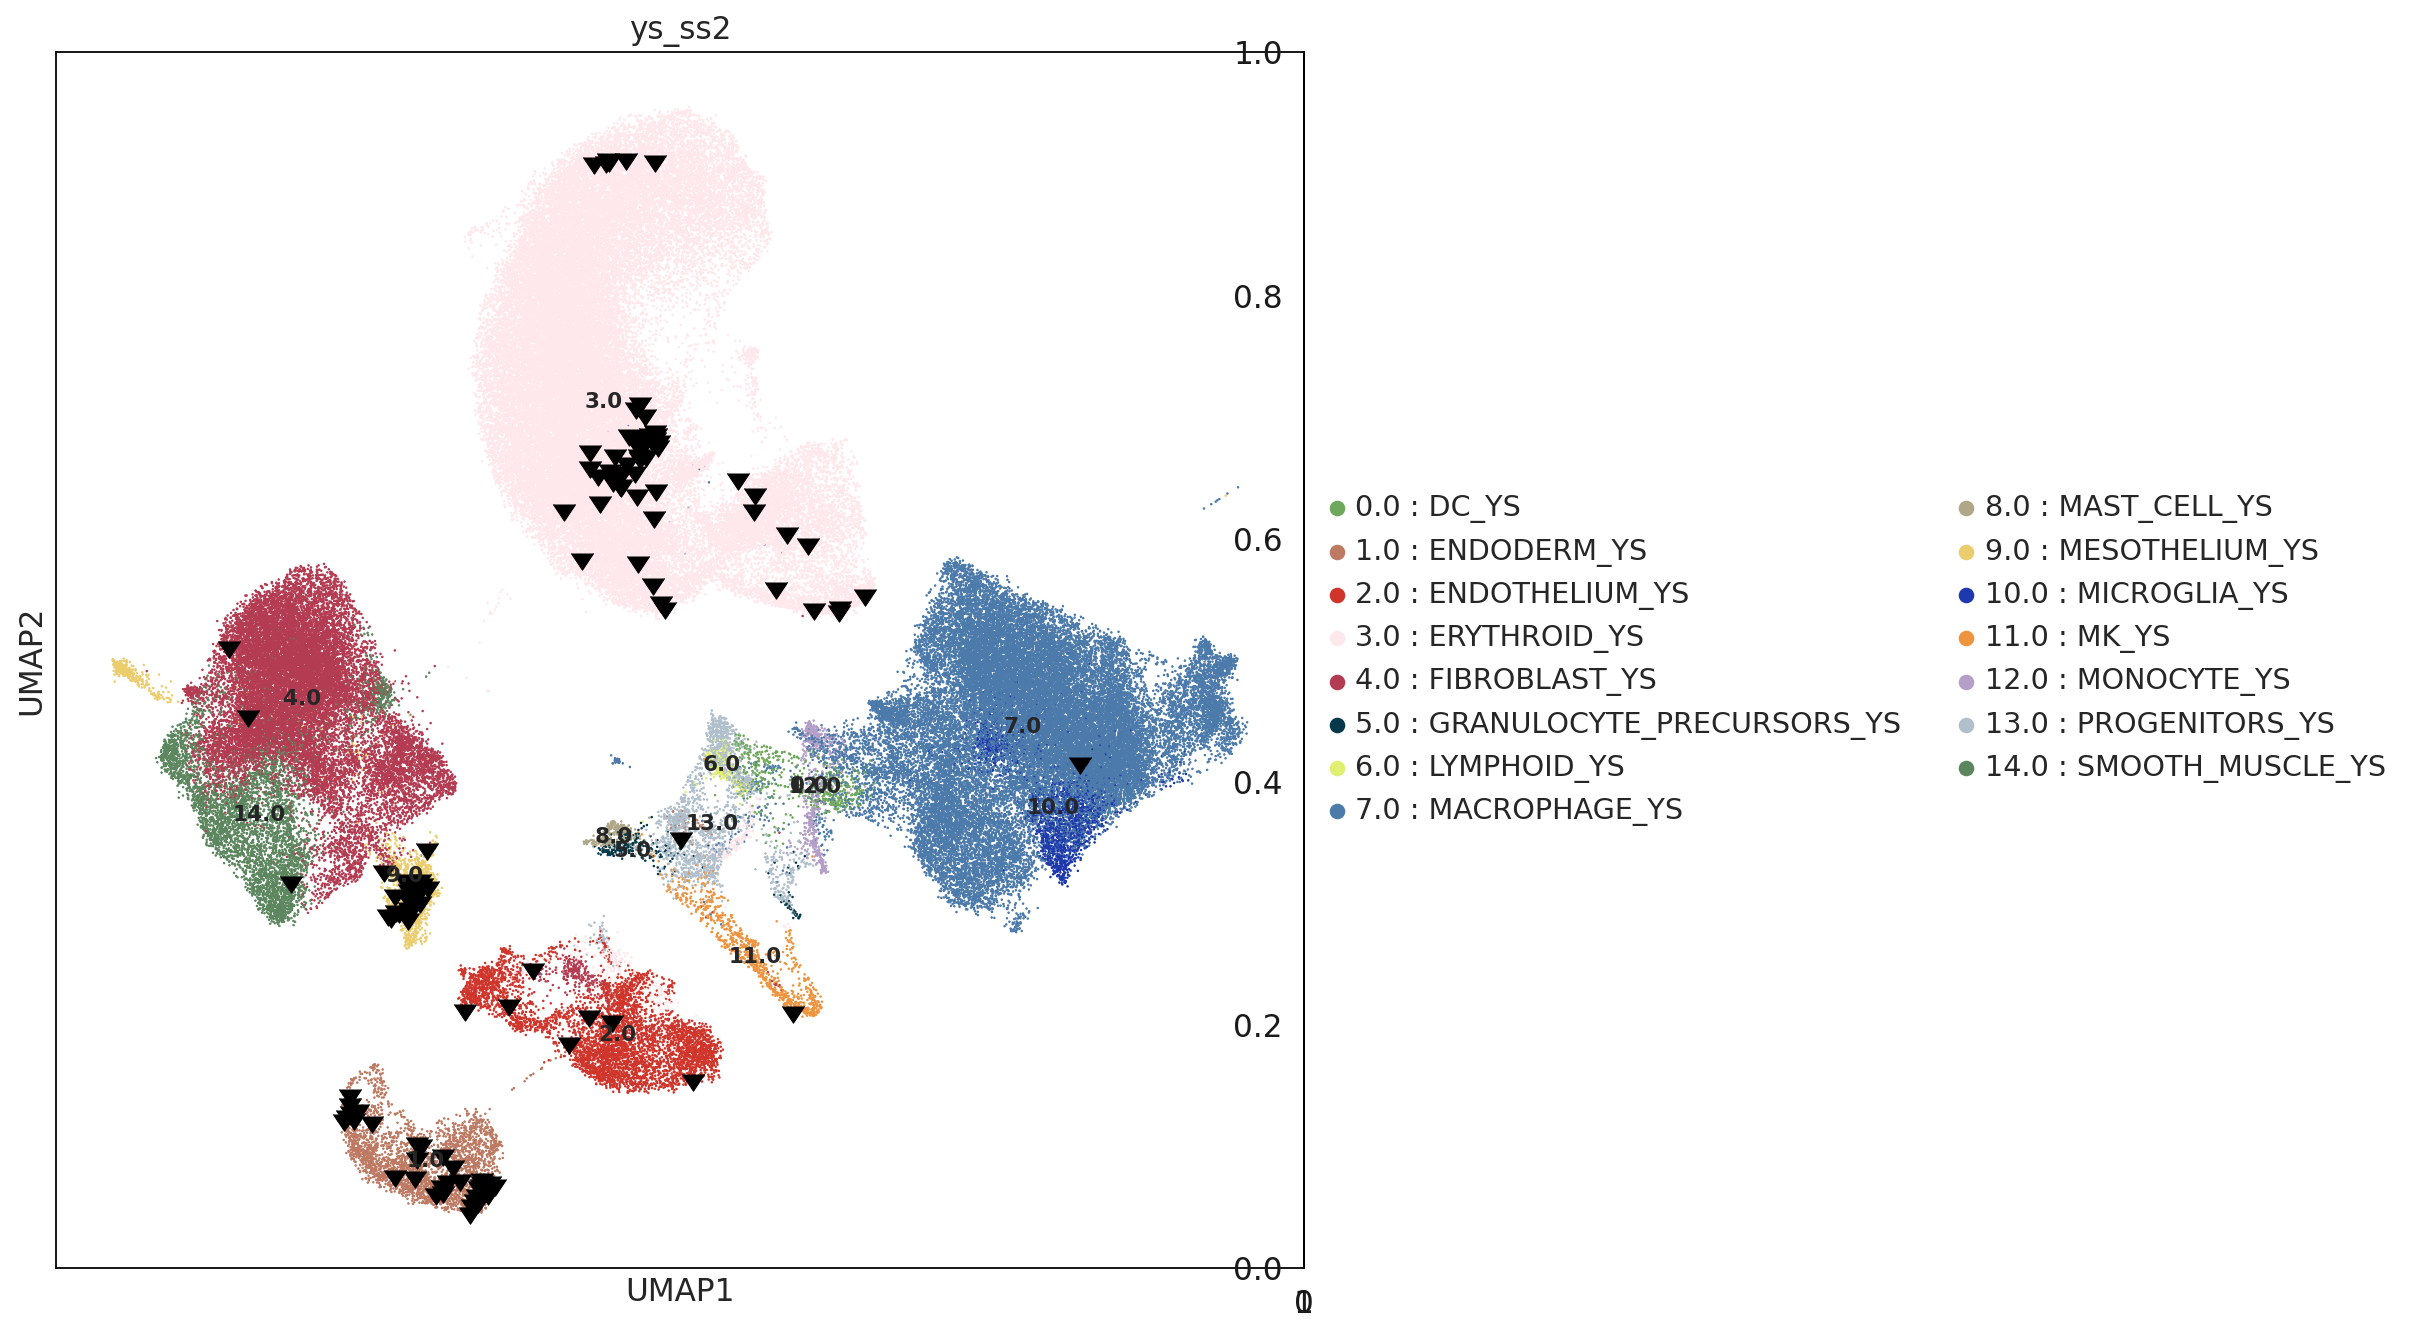

In [137]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata[adata.obs["seq_source"].isin([plot_tissue])], color = (var+'_num') ,ax=ax1,size=5,show=False,title="", palette= col_pal) #title=i
#p4 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = "seq_source" ,ax=ax1,show=False,title="", palette= ["#ff0000"],s=100) #title=i
p3 = sc.pl.umap(adata[adata.obs["seq_source"].isin([plot_tissue])], color = "num",legend_loc="on data",size=2,legend_fontsize='x-small',ax=ax1,show=False,title="ys_ss2", palette= col_pal) #title=i
ax1.scatter(adata.obsm['X_umap'][:,0][~adata.obs["seq_source"].isin([plot_tissue])], adata.obsm['X_umap'][:,1][~adata.obs["seq_source"].isin([plot_tissue])],c='#000000', s=100,marker=11,linewidth=0.5,edgecolors='r')
fig.savefig('./'+var+"_21_11_21_Overall_ss2_ys_overlay_"+plot_tissue+"_num.pdf",bbox_inches='tight')

# Plot just SS2

In [132]:
cell_label_pal = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_cell_labels_pal.csv")
broad_cell_label_pal = ('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/broad_cell_labels_pal.csv')
ys_fliv_broad = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/broad_cell_labels_ys_fliv_pal.csv")
broad_cell_label_ss2_pal = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_broad_cell_labels_with_hepa_SS2.csv'
ys_ss2_cols = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_ss2_cols.csv")
hepa_ss2_broad = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_broad_cell_labels_with_hepa_SS2.csv'

In [133]:
adata.obs

,seq_source,lane_id,cell.labels,fetal_ids,lr_batch,corr_concat,n_genes,n_counts,orig_ident,percent_mito,...,predicted_301020_microglia_assignment,lvl_1_cell.labels,lvl_2_cell.labels,cell_labels,broad_cell_labels,batch,col,var,num,var_num
WSSS_F_Imm8725442,SS2,WSSS_F_Imm8725442,Erythroid_SC_train,SS2,SS2,WSSS_F_Imm8725442_predicted_SS2,nan,4008.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ERYTHROID_SC_TRAIN,nan,nan : ERYTHROID_SC_TRAIN
WSSS_F_Imm8725443,SS2,WSSS_F_Imm8725443,Hepatoid_SC_train,SS2,SS2,WSSS_F_Imm8725443_predicted_SS2,nan,796746.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,HEPATOID_SC_TRAIN,nan,nan : HEPATOID_SC_TRAIN
WSSS_F_Imm8725444,SS2,WSSS_F_Imm8725444,Angiogenic_SC_train,SS2,SS2,WSSS_F_Imm8725444_predicted_SS2,nan,1212020.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ANGIOGENIC_SC_TRAIN,nan,nan : ANGIOGENIC_SC_TRAIN
WSSS_F_Imm8725445,SS2,WSSS_F_Imm8725445,Epithelial_SC_train,SS2,SS2,WSSS_F_Imm8725445_predicted_SS2,nan,1345123.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,EPITHELIAL_SC_TRAIN,nan,nan : EPITHELIAL_SC_TRAIN
WSSS_F_Imm8725446,SS2,WSSS_F_Imm8725446,Erythroid_SC_train,SS2,SS2,WSSS_F_Imm8725446_predicted_SS2,nan,850257.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ERYTHROID_SC_TRAIN,nan,nan : ERYTHROID_SC_TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG,nan,nan,Erythroid,F80,F80,Erythroid_SC_train,888,9451.0,F80,0.0056770395290159795,...,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,1,#94BFB1,ERYTHROID,7.0,7.0 : ERYTHROID
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG,nan,nan,LYVE1+_Endothelium,F80,F80,LYVE1+_Endothelium_SC_train,3528,14698.0,F80,0.0382404064714534,...,LYVE1+_Endothelium,LYVE1+_Endothelium,LYVE1+_Endothelium,LYVE1+_Endothelium,LYVE1+_Endothelium,1,nan,LYVE1+_ENDOTHELIUM,14.0,14.0 : LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG,nan,nan,LYVE1+_Endothelium,F80,F80,LYVE1+_Endothelium_SC_train,3412,13961.0,F80,0.04288020211944698,...,LYVE1+_Endothelium,LYVE1+_Endothelium,LYVE1+_Endothelium,LYVE1+_Endothelium,LYVE1+_Endothelium,1,nan,LYVE1+_ENDOTHELIUM,14.0,14.0 : LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT,nan,nan,Erythroid,F80,F80,Erythroid_SC_train,1104,12217.0,F80,0.009442409442409443,...,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid,1,#94BFB1,ERYTHROID,7.0,7.0 : ERYTHROID


In [134]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].str.replace('Hepatoid_','Endoderm_')
adata.obs['cell.labels'] = adata.obs['cell.labels'].str.replace('_SC_train','')
adata.obs['cell.labels'] = adata.obs['cell.labels'].astype(str).str.upper()


In [135]:
cells = list(adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'cell.labels'].unique())
cells

['Erythroid_SC_train',
 'Hepatoid_SC_train',
 'Angiogenic_SC_train',
 'Epithelial_SC_train',
 'Fibroblast_SC_train',
 'Megakaryocyte_SC_train',
 'Smooth_Muscle_SC_train']

In [141]:
cells = list(adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'cell.labels'].unique())
col = ['Erythroid_SC_train',
 'Endoderm_SC_train',
 'Endothelium_SC_train',
 'Mesothelium_SC_train',
 'Fibroblast_SC_train',
 'Megakaryocyte_SC_train',
 'Smooth_Muscle_SC_train']
dic = dict(zip(cells,col))
dic

adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'cell.labels'] = adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'cell.labels'].map(dic)

cells = list(adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'cell.labels'].unique())
dic = dict(zip(cells,col))

adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'cell.labels'] = adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'cell.labels'].map(dic)
adata.obs['cell.labels'] = adata.obs['cell.labels'].str.replace('_SC_train','')

In [142]:
#ss2 = adata[adata.obs['seq_source'].isin(['SS2'])]
#ss2.write('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/updated_ss2_data.h5ad')

In [143]:
## Vars
adata_var = "cell.labels"
col_pal = ys_ss2_cols
plot_tissue = 'SS2'

In [144]:
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
adata.obs["var"] = adata.obs[adata_var]
var = 'var'
adata.obs['var'] = adata.obs['var'].astype(str).str.upper()

#Not in intersect
intersecting = set(list(pal["categories"])) & set(list(adata.obs['var'].unique()))
print(len(intersecting),intersecting)
print("non_intersect",set(list(pal["categories"])) ^ set(cells))

7 {'ERYTHROID', 'MESOTHELIUM', 'SMOOTH_MUSCLE', 'ENDODERM', 'MEGAKARYOCYTE', 'ENDOTHELIUM', 'FIBROBLAST'}
non_intersect {'Smooth_Muscle_SC_train', 'ENDODERM', 'SMOOTH_MUSCLE', 'Fibroblast_SC_train', 'Endothelium_SC_train', 'MEGAKARYOCYTE', 'ERYTHROID', 'MESOTHELIUM', 'Megakaryocyte_SC_train', 'ENDOTHELIUM', 'Endoderm_SC_train', 'FIBROBLAST', 'Erythroid_SC_train', 'Mesothelium_SC_train'}


In [145]:
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
pal

,categories,color
0,ENDODERM,#BD7961
1,ERYTHROID,#FFE8EC
2,ENDOTHELIUM,#D0352B
3,MESOTHELIUM,#ECCD6E
4,FIBROBLAST,#B43C52
5,MEGAKARYOCYTE,#EE943F
6,SMOOTH_MUSCLE,#5C865E


# Minor Corrections

In [146]:
adata.obs["var"] = adata.obs["var"].str.replace('_SC_TRAIN','')
#pal["categories"] = pal["categories"].str.replace('PREMONOCYTE','PROMONOCYTE')
#adata.obs["var"] = adata.obs["var"].str.replace(' ','_')

In [147]:
adata.obs["var"] 

WSSS_F_Imm8725442                                           ERYTHROID
WSSS_F_Imm8725443                                            ENDODERM
WSSS_F_Imm8725444                                         ENDOTHELIUM
WSSS_F_Imm8725445                                         MESOTHELIUM
WSSS_F_Imm8725446                                           ERYTHROID
                                                          ...        
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG             ERYTHROID
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG    LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG    LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT             ERYTHROID
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA            EPITHELIUM
Name: var, Length: 124000, dtype: object

In [148]:
pal

,categories,color
0,ENDODERM,#BD7961
1,ERYTHROID,#FFE8EC
2,ENDOTHELIUM,#D0352B
3,MESOTHELIUM,#ECCD6E
4,FIBROBLAST,#B43C52
5,MEGAKARYOCYTE,#EE943F
6,SMOOTH_MUSCLE,#5C865E


In [149]:
cells = list(adata.obs.loc[adata.obs['seq_source'].isin(['SS2']),'var'].unique())
print("non_intersect",set(list(pal["categories"])) ^ set(list(cells)))

non_intersect set()


# Create mappable field

In [150]:
cells = list(adata.obs["var"][adata.obs["seq_source"].isin([plot_tissue])].unique())
cells.sort()
pal = pal[pal["categories"].isin(cells)]
#cells.append(alternate_name)
col = list(range(0,len(cells)))
#Add gray color for alternate category
#pal.loc[len(pal)+1]= [alternate_name,"#808080"]
pal = pal.set_index('categories')
pal = pal.loc[cells]
col_pal = list(pal["color"])

In [151]:
pal

,color
categories,
ENDODERM,#BD7961
ENDOTHELIUM,#D0352B
ERYTHROID,#FFE8EC
FIBROBLAST,#B43C52
MEGAKARYOCYTE,#EE943F
MESOTHELIUM,#ECCD6E
SMOOTH_MUSCLE,#5C865E


In [152]:
#Create a mappable field
dic = dict(zip(list(pal.index),list(pal["color"])))
adata.obs['ss2_col'] = adata.obs['var']
#map to adata.obs.col to create a caterorical column
adata.obs['ss2_col'] = adata.obs['ss2_col'].map(dic)

In [153]:
adata.obs['num']

WSSS_F_Imm8725442                                   nan
WSSS_F_Imm8725443                                   nan
WSSS_F_Imm8725444                                   nan
WSSS_F_Imm8725445                                   nan
WSSS_F_Imm8725446                                   nan
                                                   ... 
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG     7.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG    14.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG    14.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT     7.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA     6.0
Name: num, Length: 124000, dtype: category
Categories (31, object): ['0.0', '1.0', '2.0', '3.0', ..., '27.0', '28.0', '29.0', 'nan']

In [154]:
adata.obs[var+'_num']

WSSS_F_Imm8725442                                   nan : ERYTHROID_SC_TRAIN
WSSS_F_Imm8725443                                    nan : HEPATOID_SC_TRAIN
WSSS_F_Imm8725444                                  nan : ANGIOGENIC_SC_TRAIN
WSSS_F_Imm8725445                                  nan : EPITHELIAL_SC_TRAIN
WSSS_F_Imm8725446                                   nan : ERYTHROID_SC_TRAIN
                                                             ...            
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG              7.0 : ERYTHROID
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG    14.0 : LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG    14.0 : LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT              7.0 : ERYTHROID
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA             6.0 : EPITHELIUM
Name: var_num, Length: 124000, dtype: category
Categories (37, object): ['0.0 : CMP', '1.0 : DC2', '2.0 : EARLY_ERYTHROID', '3.0 : ENDODERM', ..., 'nan :

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell.labels' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to

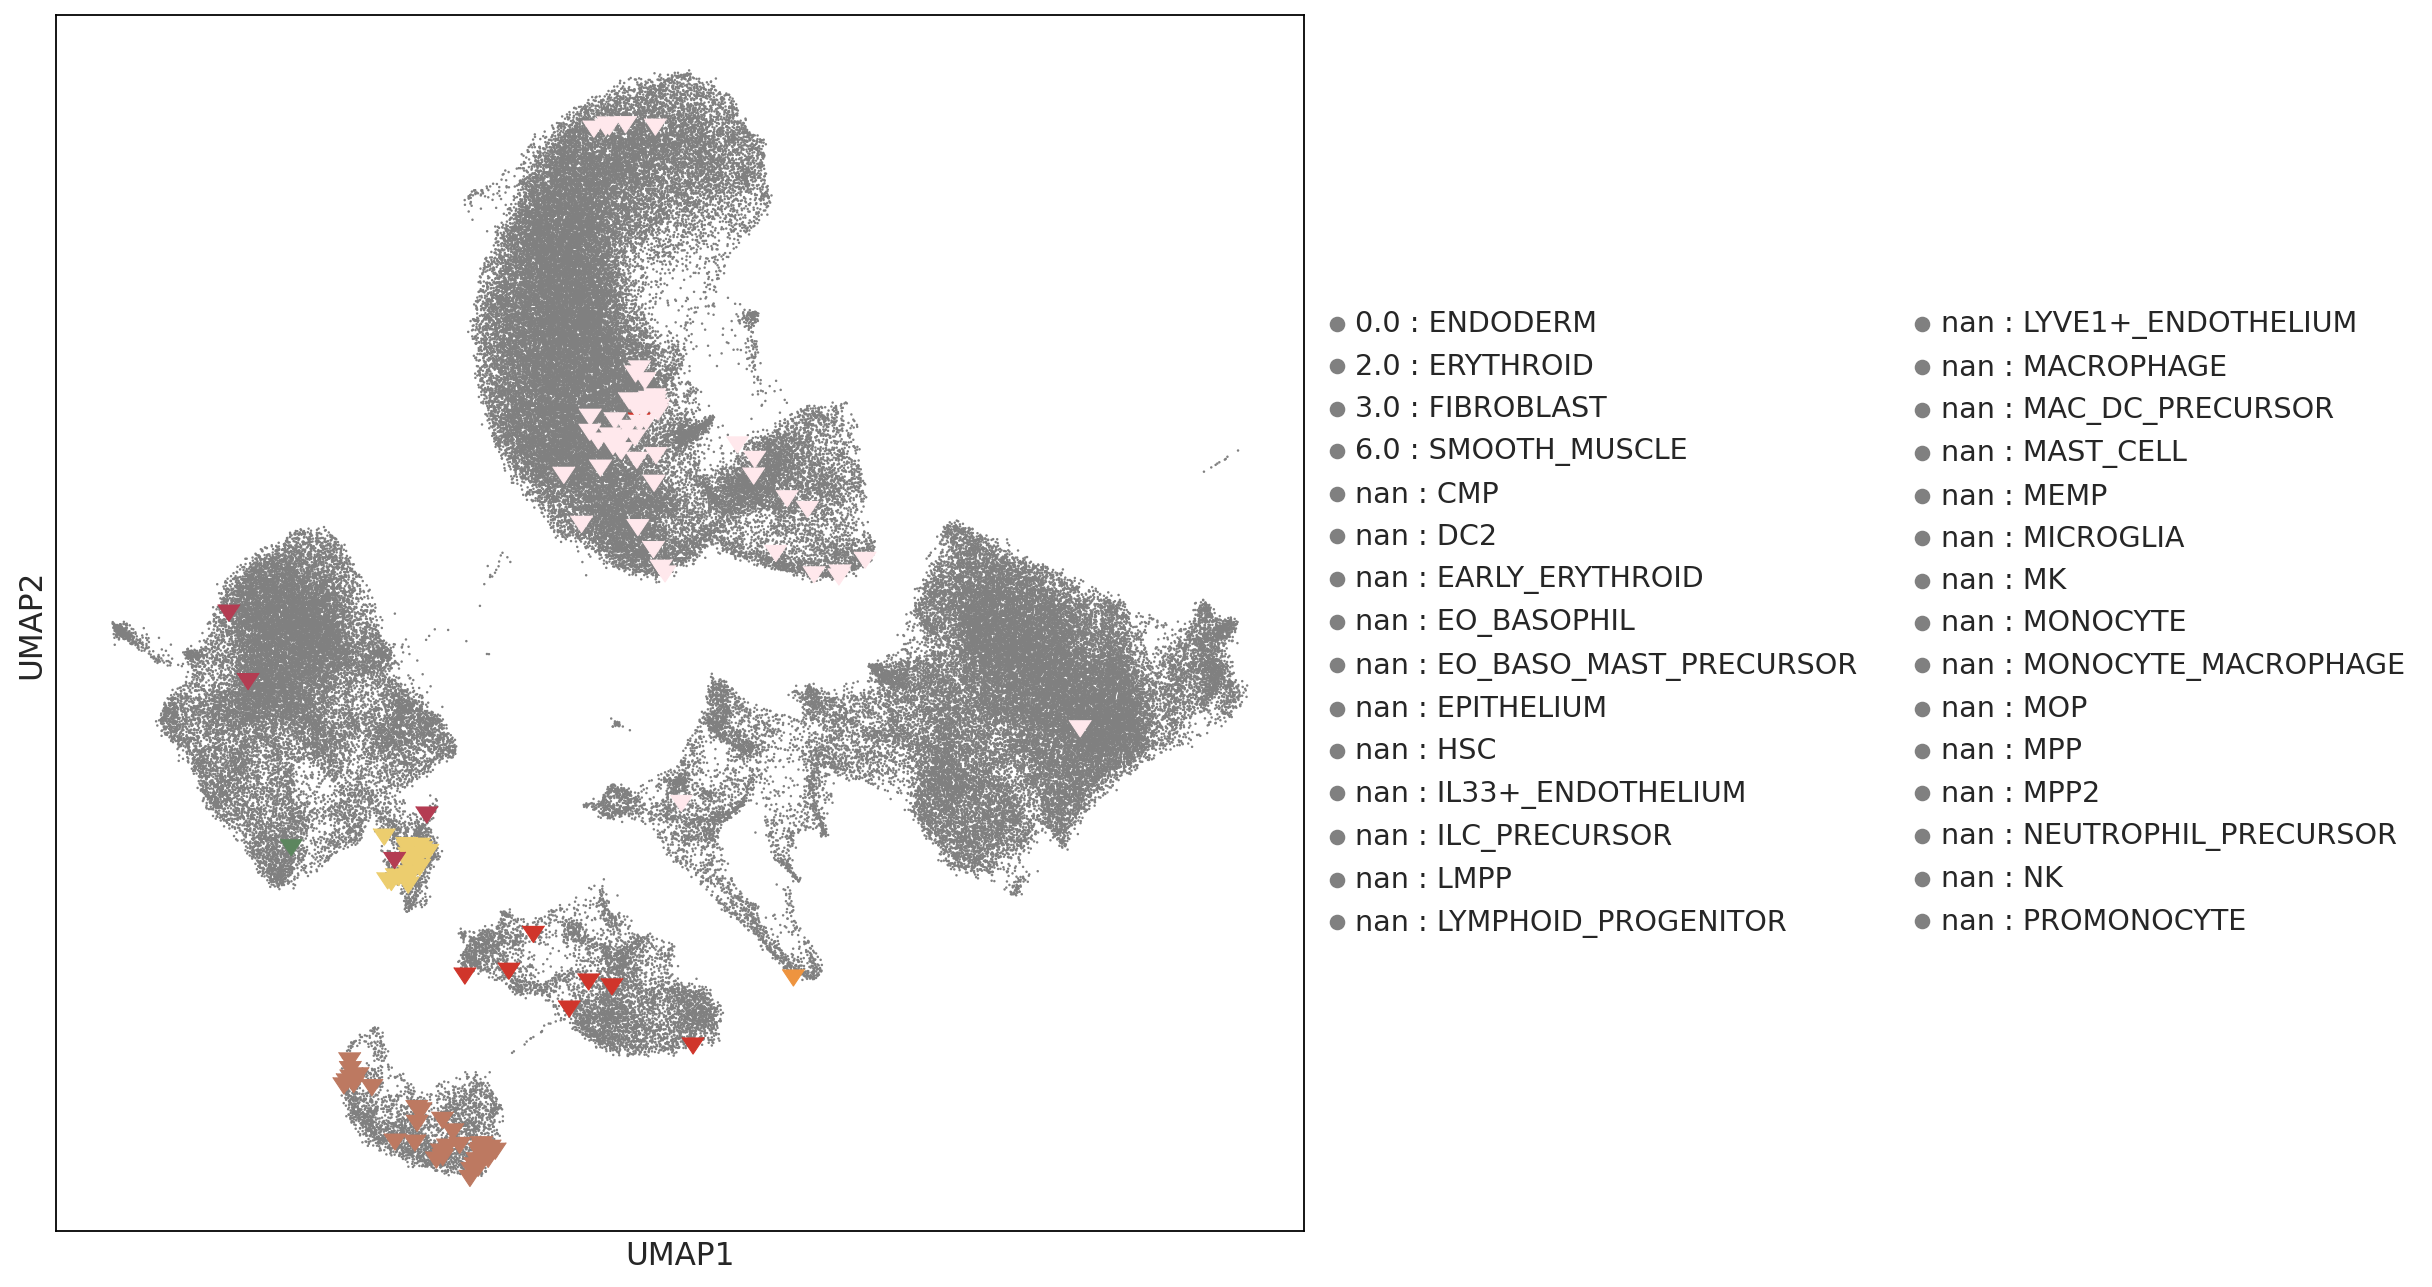

In [155]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
fig, (ax1) = plt.subplots(1, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1]})
p2 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = (var+'_num') ,ax=ax1,size=5,show=False,title="",  palette= ["#808080"]) #title=i
#p4 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = "seq_source" ,ax=ax1,show=False,title="", palette= ["#ff0000"],s=100) #title=i
#p3 = sc.pl.umap(adata[adata.obs["seq_source"].isin([plot_tissue])], color = "num",legend_loc="on data",size=2,legend_fontsize='x-small',ax=ax1,show=False,title="ys_ss2", palette= col_pal) #title=i
ax1.scatter(adata.obsm['X_umap'][:,0][adata.obs["seq_source"].isin([plot_tissue])], adata.obsm['X_umap'][:,1][adata.obs["seq_source"].isin([plot_tissue])],c=adata.obs['ss2_col'][adata.obs["seq_source"].isin([plot_tissue])], s=100,marker=11,linewidth=0.5,edgecolors='r')
fig.savefig('./'+var+"_just_ss2_ys_overlay_"+plot_tissue+"_num.pdf",bbox_inches='tight')

In [138]:
cell_label_pal = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_cell_labels_pal.csv")
broad_cell_label_pal = ('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/broad_cell_labels_pal.csv')
ys_fliv_broad = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/YS_fliv_broad_pal.csv")
ys_ss2_cols = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_ss2_cols.csv")

In [145]:
## Vars
adata_var = "cell.labels"
col_pal = ys_ss2_cols
plot_tissue = 'SS2'

In [146]:
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
adata.obs["var"] = adata.obs[adata_var]
var = 'var'
adata.obs['var'] = adata.obs['var'].astype(str).str.upper()

#Not in intersect
intersecting = set(list(pal["categories"])) & set(list(adata.obs['var'].unique()))
print(len(intersecting),intersecting)
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

6 {'FIBROBLAST', 'ENDOTHELIUM', 'ERYTHROID', 'SMOOTH_MUSCLE', 'MESOTHELIUM', 'ENDODERM'}
non_intersect {'MACROPHAGE', 'LYMPHOID', 'PROGENITORS', 'DC', 'MAST_CELL', 'MEGAKARYOCYTE_SC_TRAIN', 'GRANULOCYTE_PRECURSORS', 'MK', 'HEPATOID_SC_TRAIN', 'MEGAKARYOCYTE', 'SMOOTH_MUSCLE_SC_TRAIN', 'ERYTHROID_SC_TRAIN', 'MONOCYTE', 'FIBROBLAST_SC_TRAIN', 'ANGIOGENIC_SC_TRAIN', 'EPITHELIAL_SC_TRAIN', 'MICROGLIA'}


In [147]:
met = pd.read_csv('nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/UMAPS_and_SS2_overlay/SS2_meta.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/UMAPS_and_SS2_overlay/SS2_meta.csv'

# Minor Corrections

In [141]:
adata.obs["var"] = adata.obs["var"].str.replace('_SC_TRAIN','')
#pal["categories"] = pal["categories"].str.replace('PREMONOCYTE','PROMONOCYTE')
#adata.obs["var"] = adata.obs["var"].str.replace(' ','_')

In [142]:
print("non_intersect",set(list(pal["categories"])) ^ set(list(cells)))

non_intersect {'FIBROBLAST_YS', 'MACROPHAGE_YS', 'DC_YS', 'MICROGLIA_YS', 'MEGAKARYOCYTE', 'ENDOTHELIUM_YS', 'MESOTHELIUM_YS', 'PROGENITORS_YS', 'SMOOTH_MUSCLE', 'MESOTHELIUM', 'ERYTHROID_YS', 'FIBROBLAST', 'SMOOTH_MUSCLE_YS', 'ENDODERM_YS', 'GRANULOCYTE_PRECURSORS_YS', 'MAST_CELL_YS', 'ENDODERM', 'ENDOTHELIUM', 'ERYTHROID', 'MK_YS', 'LYMPHOID_YS', 'MONOCYTE_YS'}


# Create mappable field

In [143]:
cells = list(adata.obs["var"][adata.obs["seq_source"].isin([plot_tissue])].unique())
cells.sort()
pal = pal[pal["categories"].isin(cells)]
#cells.append(alternate_name)
col = list(range(0,len(cells)))
#Add gray color for alternate category
#pal.loc[len(pal)+1]= [alternate_name,"#808080"]
pal = pal.set_index('categories')
pal = pal.loc[cells]
col_pal = list(pal["color"])

KeyError: "['ANGIOGENIC', 'EPITHELIAL', 'HEPATOID'] not in index"

In [144]:
pal

,color
categories,
ERYTHROID,#FFE8EC
FIBROBLAST,#B43C52
MEGAKARYOCYTE,#EE943F
SMOOTH_MUSCLE,#5C865E


In [125]:
#Create a mappable field
dic = dict(zip(list(pal.index),list(pal["color"])))
adata.obs['ss2_col'] = adata.obs['var']
#map to adata.obs.col to create a caterorical column
adata.obs['ss2_col'] = adata.obs['ss2_col'].map(dic)

In [126]:
adata.obs['num']

WSSS_F_Imm8725442                                   nan
WSSS_F_Imm8725443                                   nan
WSSS_F_Imm8725444                                   nan
WSSS_F_Imm8725445                                   nan
WSSS_F_Imm8725446                                   nan
                                                   ... 
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG     7.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG    14.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG    14.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT     7.0
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA     6.0
Name: num, Length: 125655, dtype: object

In [127]:
adata.obs[var+'_num']

WSSS_F_Imm8725442                                   nan : ERYTHROID_SC_TRAIN
WSSS_F_Imm8725443                                    nan : HEPATOID_SC_TRAIN
WSSS_F_Imm8725444                                  nan : ANGIOGENIC_SC_TRAIN
WSSS_F_Imm8725445                                  nan : EPITHELIAL_SC_TRAIN
WSSS_F_Imm8725446                                   nan : ERYTHROID_SC_TRAIN
                                                             ...            
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG              7.0 : ERYTHROID
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG    14.0 : LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG    14.0 : LYVE1+_ENDOTHELIUM
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT              7.0 : ERYTHROID
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA             6.0 : EPITHELIUM
Name: var_num, Length: 125655, dtype: object

In [ ]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
fig, (ax1) = plt.subplots(1, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1]})
p2 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = (var+'_num') ,ax=ax1,size=5,show=False,title="",  palette= ["#808080"]) #title=i
#p4 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = "seq_source" ,ax=ax1,show=False,title="", palette= ["#ff0000"],s=100) #title=i
#p3 = sc.pl.umap(adata[adata.obs["seq_source"].isin([plot_tissue])], color = "num",legend_loc="on data",size=2,legend_fontsize='x-small',ax=ax1,show=False,title="ys_ss2", palette= col_pal) #title=i
ax1.scatter(adata.obsm['X_umap'][:,0][adata.obs["seq_source"].isin([plot_tissue])], adata.obsm['X_umap'][:,1][adata.obs["seq_source"].isin([plot_tissue])],c=adata.obs['ss2_col'][adata.obs["seq_source"].isin([plot_tissue])], s=100,marker=11,linewidth=0.5,edgecolors='r')
fig.savefig('./'+var+"_just_ss2_ys_overlay_"+plot_tissue+"_num.pdf",bbox_inches='tight')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell.labels' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var_num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ss2_col' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'var' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var_num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ss2_col' as categorical


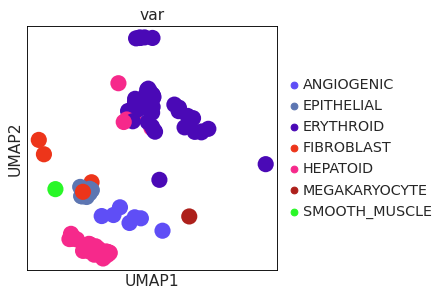

In [155]:
sc.pl.umap(adata[adata.obs["seq_source"].isin([plot_tissue])], color ='var',palette= col_pal,save = "ss2_color_guide")

# SS2 endoderm on YS broad_cell.labels x2 (one coloured, one with 10x in grey)

In [4]:
predicted_ss2_labels = pd.read_csv("./predicted_ss2_labbels.csv",index_col=0)

In [5]:
adata = sc.read(save_path + "A1.210312_combined_YS_SS2.h5ad")

In [6]:
#Remove some outliers
remove = ["WSSS_F_Imm8725543","WSSS_F_Imm8725449","WSSS_F_Imm8725507","WSSS_F_Imm8725441","WSSS_F_Imm8725584","WSSS_F_Imm8725535"]
adata = adata[~adata.obs.index.isin(remove)]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [7]:
adata.obs["broad_cell_labels"] = adata.obs["broad_cell_labels"].astype(str)
adata.obs['broad_cell_labels'].loc[adata.obs.index.isin(list(predicted_ss2_labels.index))]= predicted_ss2_labels["clus_prediction"].astype(str)
#filter adata for any ss2 not in mapping
adata = adata[~adata.obs["broad_cell_labels"].isin(["SS2"])]

Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
cell_label_pal = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_cell_labels_pal.csv")
broad_cell_label_pal = ('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/broad_cell_labels_pal.csv')
ys_fliv_broad = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/YS_fliv_broad_pal.csv")
ys_ss2_cols = ("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_ss2_cols.csv")
hepa_ss2 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/ys_broad_cell_labels_with_hepa_SS2.csv"

In [9]:
## Vars
adata_var = "broad_cell_labels"
col_pal = hepa_ss2
plot_tissue = 'SS2'
keep_ss2 = 'HEPATOID_SS2'

In [10]:
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
adata.obs["var"] = adata.obs[adata_var]
var = 'var'
adata.obs['var'] = adata.obs['var'].astype(str).str.upper()

Trying to set attribute `.obs` of view, copying.


In [11]:
list(adata.obs["var"].unique())

['ERYTHROID_SC_TRAIN',
 'HEPATOID_SC_TRAIN',
 'ANGIOGENIC_SC_TRAIN',
 'EPITHELIAL_SC_TRAIN',
 'FIBROBLAST_SC_TRAIN',
 'MEGAKARYOCYTE_SC_TRAIN',
 'SMOOTH_MUSCLE_SC_TRAIN',
 'ERYTHROID',
 'DC',
 'LYMPHOID',
 'MK',
 'MACROPHAGE',
 'MONOCYTE',
 'PROGENITOR',
 'GRANULOCYTE_PRECURSOR',
 'EPITHELIUM',
 'ENDODERM',
 'MICROGLIA',
 'MAST_CELL',
 'FIBROBLAST',
 'LYVE1+_ENDOTHELIUM',
 'SMOOTH_MUSCLE',
 'IL33+_ENDOTHELIUM']

# Minor Corrections

In [12]:
adata.obs["var"] = adata.obs["var"].str.replace('HEPATOID_SC_TRAIN','HEPATOID_SS2')
keep = list((adata.obs['var'][~adata.obs['seq_source'].isin([plot_tissue])]).unique())
keep.append(keep_ss2)
adata = adata[adata.obs['var'].isin(keep)]
#pal["categories"] = pal["categories"].str.replace('PREMONOCYTE','PROMONOCYTE')
#adata.obs["var"] = adata.obs["var"].str.replace(' ','_')
#Not in intersect
intersecting = set(list(pal["categories"])) & set(list(adata.obs['var'].unique()))
print(len(intersecting),intersecting)
print("non_intersect",set(list(pal["categories"])) ^ set(list(adata.obs['var'].unique())))

16 {'SMOOTH_MUSCLE', 'FIBROBLAST', 'GRANULOCYTE_PRECURSOR', 'MAST_CELL', 'ENDODERM', 'IL33+_ENDOTHELIUM', 'EPITHELIUM', 'HEPATOID_SS2', 'MK', 'MACROPHAGE', 'MONOCYTE', 'MICROGLIA', 'LYVE1+_ENDOTHELIUM', 'LYMPHOID', 'ERYTHROID', 'DC'}
non_intersect {'PROGENITOR', 'PROGENITORS'}


# Create mappable field

In [138]:
cells = list(adata.obs["var"][adata.obs["seq_source"].isin([plot_tissue])].unique())
cells.sort()
pal = pal[pal["categories"].isin(cells)]
#cells.append(alternate_name)
col = list(range(0,len(cells)))
#Add gray color for alternate category
#pal.loc[len(pal)+1]= [alternate_name,"#808080"]
pal = pal.set_index('categories')
pal = pal.loc[cells]
col_pal = list(pal["color"])

In [139]:
pal

,color
categories,
HEPATOID_SS2,#F6298B


In [140]:
#Create a mappable field
dic = dict(zip(list(pal.index),list(pal["color"])))
adata.obs['ss2_col'] = adata.obs['var']
#map to adata.obs.col to create a caterorical column
adata.obs['ss2_col'] = adata.obs['ss2_col'].map(dic)

Trying to set attribute `.obs` of view, copying.


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'broad_cell_labels' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var_num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ss2_col' as categorical


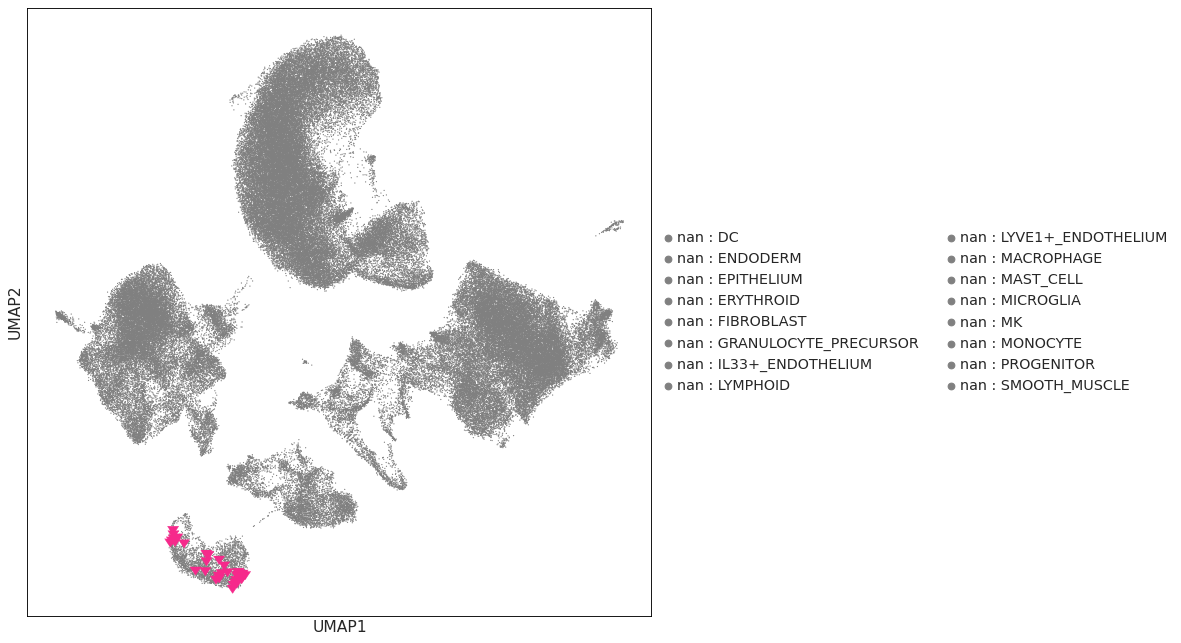

In [141]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
fig, (ax1) = plt.subplots(1, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1]})
p2 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = (var+'_num') ,ax=ax1,size=5,show=False,title="",  palette= ["#808080"]) #title=i
#p4 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = "seq_source" ,ax=ax1,show=False,title="", palette= ["#ff0000"],s=100) #title=i
#p3 = sc.pl.umap(adata[adata.obs["seq_source"].isin([plot_tissue])], color = "num",legend_loc="on data",size=2,legend_fontsize='x-small',ax=ax1,show=False,title="ys_ss2", palette= col_pal) #title=i
ax1.scatter(adata.obsm['X_umap'][:,0][adata.obs["seq_source"].isin([plot_tissue])], adata.obsm['X_umap'][:,1][adata.obs["seq_source"].isin([plot_tissue])],c=adata.obs['ss2_col'][adata.obs["seq_source"].isin([plot_tissue])], s=100,marker=11,linewidth=0.5,edgecolors='r')
fig.savefig('./'+var+"_hepa_ss2_ys_overlay_"+plot_tissue+"_num.pdf",bbox_inches='tight')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'broad_cell_labels' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var_num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ss2_col' as categorical


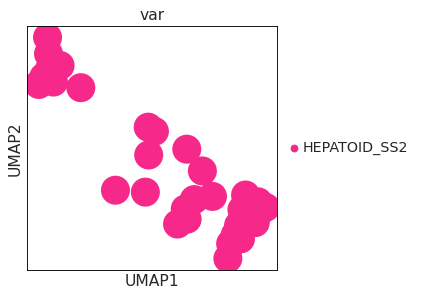

In [142]:
sc.pl.umap(adata[adata.obs["seq_source"].isin([plot_tissue])], color ='var',palette= col_pal,save = "hepa_ss2_color_guide")

# Plot SS2 and broad cell.labels

In [13]:
adata.obs["var"] = adata.obs["var"].str.replace('PROGENITOR','PROGENITORS')

Trying to set attribute `.obs` of view, copying.


In [14]:
cells = list(adata.obs["var"][~adata.obs["seq_source"].isin([plot_tissue])].unique())
cells.sort()
#Check if all cats are indeed available
pal = pd.read_csv(col_pal)
#Uppercase everything
pal = pal.apply(lambda x: x.astype(str).str.upper())
pal = pal[pal["categories"].isin(cells)]
#cells.append(alternate_name)
col = list(range(0,len(cells)))

pal = pal.set_index('categories')
pal = pal.loc[cells]
col_pal = list(pal["color"])

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'broad_cell_labels' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var_num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'broad_cell_labels' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'var_num' as categorical


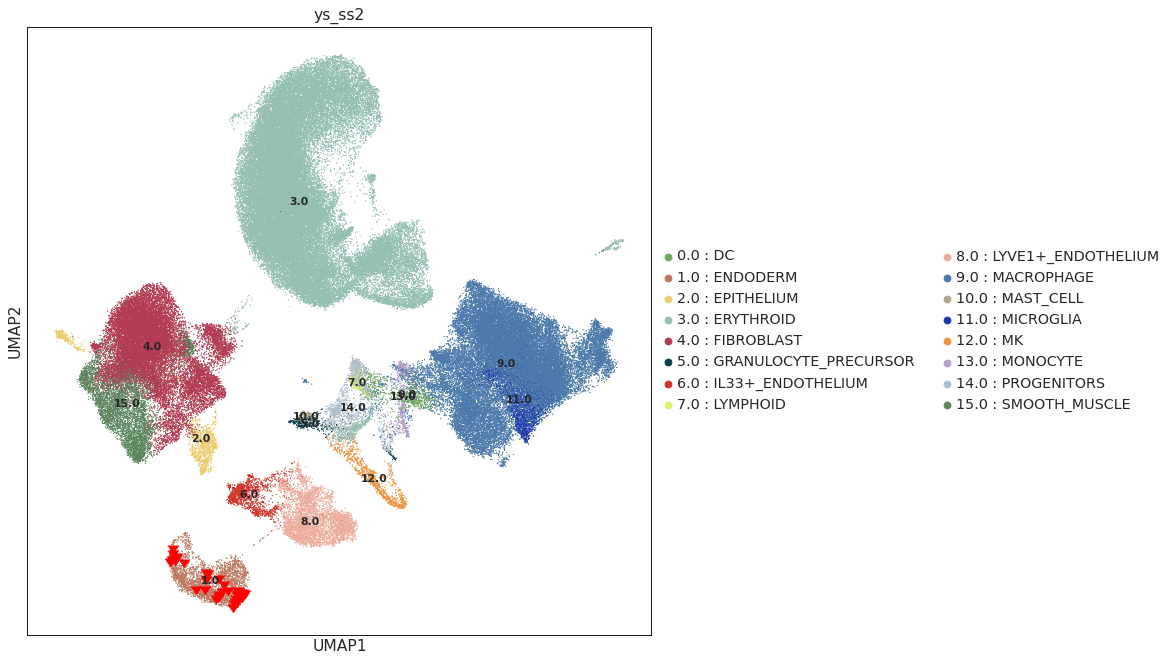

In [15]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
fig, (ax1) = plt.subplots(1, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1]})
p2 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = (var+'_num') ,ax=ax1,size=5,show=False,title="", palette= col_pal) #title=i
#p4 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = "seq_source" ,ax=ax1,show=False,title="", palette= ["#ff0000"],s=100) #title=i
p3 = sc.pl.umap(adata[~adata.obs["seq_source"].isin([plot_tissue])], color = "num",legend_loc="on data",size=2,legend_fontsize='x-small',ax=ax1,show=False,title="ys_ss2", palette= col_pal) #title=i
ax1.scatter(adata.obsm['X_umap'][:,0][adata.obs["seq_source"].isin([plot_tissue])], adata.obsm['X_umap'][:,1][adata.obs["seq_source"].isin([plot_tissue])],c='#ff0000', s=100,marker=11,linewidth=0.5,edgecolors='r')
fig.savefig('./'+var+"_Overall_endoderm_ss2_ys_overlay_"+plot_tissue+"_num.pdf",bbox_inches='tight')

In [ ]:
adata = sc.read()

In [10]:
col = [
    '#ff0000',
    '#94BFB1',
    '#B49EC8',
    '#E0EE70',
    '#EE943E',
    '#4C7BAB',
    '#E78AB8',
    '#AFBFCC',
    '#814F75',
    '#B0A789',
    '#EBCD6E',
    '#B6685E',
    '#05394A',
    '#B43C52',
    '#EDAD9D',
    '#83AA85',
    '#D0352B',
    '#6EA85B',
]

In [13]:
#Create color dictionary
#cells = list(adata.obs['cell.labels'].unique())
#col = adata.uns['cell.labels_colors']
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['col'] = adata.obs["cell.labels"]
#map to adata.obs.col to create a caterorical column
adata.obs['col'] = adata.obs['col'].map(dic)

#Map to a pallete to use with umap
cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
cells_list['col'] = cells_list[0].map(dic)
col_pal = list(cells_list['col'])

In [14]:
dic

{'SS2': '#ff0000',
 'Erythroid': '#94BFB1',
 'DC2': '#B49EC8',
 'NK': '#E0EE70',
 'MK': '#EE943E',
 'Macrophage': '#4C7BAB',
 'ILC_precursor': '#E78AB8',
 'Early_Erythroid': '#AFBFCC',
 'Monocyte': '#814F75',
 'Lymphoid_progenitor': '#B0A789',
 'MPP': '#EBCD6E',
 'Mac_DC_precursor': '#B6685E',
 'Eo_Baso_Mast_precursor': '#05394A',
 'Eo_Basophil': '#B43C52',
 'Epithelium': '#EDAD9D',
 'Endoderm': '#83AA85',
 'Promonocyte': '#D0352B',
 'microglia': '#6EA85B'}

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not F32_Yolksac_Total_FCAImmP7316900_AAACCTGAGTCTCAAC    #94BFB1
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCACGCATCG    #B49EC8
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGACGCTC    #94BFB1
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGTAACGG    #94BFB1
F32_Yolksac_Total_FCAImmP7316900_AAACCTGTCACAGGCC    #94BFB1
                                                      ...   
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG      #94BFB1
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG          NaN
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG          NaN
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT      #94BFB1
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA      #EDAD9D
Name: col, Length: 125519, dtype: object

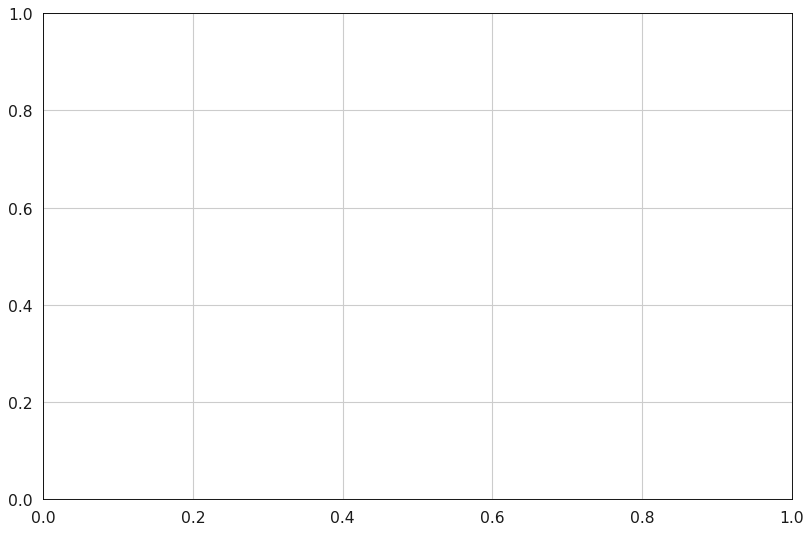

In [15]:
#Plot UMAP S2 overlay
fig, ax = plt.subplots(1,figsize=(12,8))
ax.scatter(adata.obsm['X_umap'][:,0][adata.obs["seq_source"]=="nan"], adata.obsm['X_umap'][:,1][adata.obs["seq_source"]=="nan"],c=adata.obs['col'][adata.obs["seq_source"]=="nan"],s=1)
ax.scatter(adata.obsm['X_umap'][:,0][adata.obs["seq_source"]=="SS2"], adata.obsm['X_umap'][:,1][adata.obs["seq_source"]=="SS2"],c=adata.obs['col'][adata.obs["seq_source"]=="SS2"], s=100,marker=11)
plt.savefig("./umap_SS2_overlay")

In [ ]:
sc.pl.umap(adata,color="cell.labels", palette = col_pal,title = fig_name,save=("_pre_prediction_bbknn_corrected.png"))

# Plot just hepa to hepa overlay

In [20]:
list(adata.obs["cell.labels"].unique())

['SS2',
 'Erythroid',
 'DC2',
 'NK',
 'MK',
 'Macrophage',
 'ILC_precursor',
 'Early_Erythroid',
 'Monocyte',
 'Lymphoid_progenitor',
 'MPP',
 'Mac_DC_precursor',
 'Eo_Baso_Mast_precursor',
 'Eo_Basophil',
 'Epithelium',
 'Endoderm',
 'Promonocyte',
 'microglia',
 'Monocyte_Macrophage',
 'Mast_cell',
 'Fibroblast',
 'LYVE1+_Endothelium',
 'Smooth_Muscle',
 'IL33+_Endothelium',
 'MOP',
 'LMPP',
 'Neutrophil_precursor',
 'MEMP',
 'HSC',
 'CMP',
 'MPP2']

In [21]:
#create a subset with just ss2 and hepa
adata_sub = adata[:]
keep_cells = ["SS2","Endoderm"]

#subset
adata_sub = adata_sub[adata_sub.obs["cell.labels"].isin(keep_cells)]

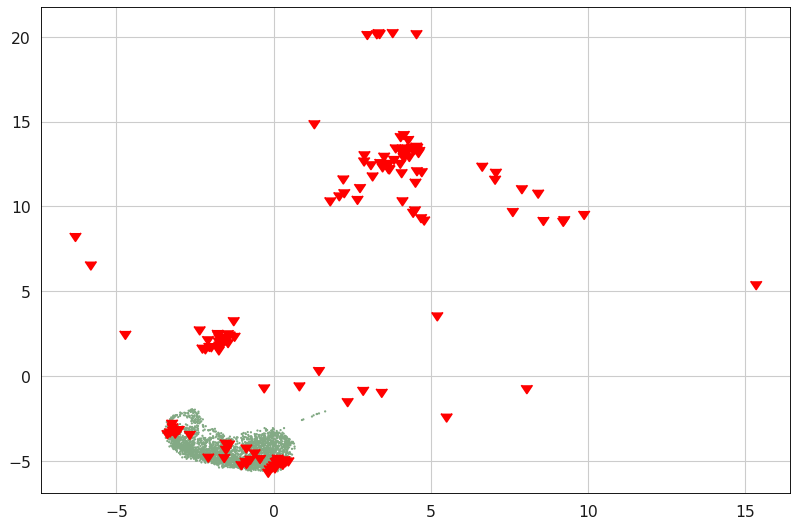

In [22]:
#Plot UMAP S2 overlay
fig, ax = plt.subplots(1,figsize=(12,8))
ax.scatter(adata_sub.obsm['X_umap'][:,0][adata_sub.obs["cell.labels"]=='Endoderm'], adata_sub.obsm['X_umap'][:,1][adata_sub.obs["cell.labels"]=='Endoderm'],c=adata_sub.obs['col'][adata_sub.obs["cell.labels"]=='Endoderm'],s=1)
ax.scatter(adata_sub.obsm['X_umap'][:,0][adata_sub.obs["seq_source"]=="SS2"], adata_sub.obsm['X_umap'][:,1][adata_sub.obs["seq_source"]=="SS2"],c=adata_sub.obs['col'][adata_sub.obs["seq_source"]=="SS2"], s=100,marker=11)
plt.savefig("./umap_SS2_overlay_just_hepa_ss2")

# plot same with cleaned SS2

In [ ]:
adata.obs["clus_prediction"]

In [ ]:
#create a subset with just ss2 and hepa
adata_sub2 = adata_sub[:]
keep_cells = ["Hepatoid_SC_train",np.nan]

#subset
adata_sub2 = adata_sub2[adata_sub2.obs["clus_prediction"].isin(keep_cells)]

In [ ]:
#Plot UMAP S2 overlay
fig, ax = plt.subplots(1,figsize=(12,8))
ax.scatter(adata_sub2.obsm['X_umap'][:,0][adata_sub2.obs["cell.labels"]=="Hepatoid"], adata_sub2.obsm['X_umap'][:,1][adata_sub2.obs["cell.labels"]=="Hepatoid"],c=adata_sub2.obs['col'][adata_sub2.obs["cell.labels"]=="Hepatoid"],s=1)
ax.scatter(adata_sub2.obsm['X_umap'][:,0][adata_sub2.obs["seq_source"]=="SS2"], adata_sub2.obsm['X_umap'][:,1][adata_sub2.obs["seq_source"]=="SS2"],c=adata_sub2.obs['col'][adata_sub2.obs["seq_source"]=="SS2"], s=100,marker=11)
plt.savefig("./figures/umap_SS2_overlay_just_hepa_ss2")

In [14]:
adata = sc.read("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/combined_ys_fliv_data_090321/A1.210312_combined_YS_SS2.h5ad")

In [16]:
out = adata.obs[adata.obs["seq_source"].isin(["SS2"])]

In [17]:
out.to_csv("./SS2_meta.csv")

In [20]:
out

,seq_source,lane_id,cell.labels,fetal_ids,lr_batch,corr_concat,n_genes,n_counts,orig_ident,percent_mito,...,predicted_301020_microglia_assignment,lvl_1_cell.labels,lvl_2_cell.labels,cell_labels,broad_cell_labels,batch,col,var,num,var_num
WSSS_F_Imm8725441,SS2,WSSS_F_Imm8725441,Hepatoid_SC_train,SS2,SS2,WSSS_F_Imm8725441_predicted_SS2,nan,55.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,HEPATOID_SC_TRAIN,nan,nan : HEPATOID_SC_TRAIN
WSSS_F_Imm8725442,SS2,WSSS_F_Imm8725442,Erythroid_SC_train,SS2,SS2,WSSS_F_Imm8725442_predicted_SS2,nan,4008.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ERYTHROID_SC_TRAIN,nan,nan : ERYTHROID_SC_TRAIN
WSSS_F_Imm8725443,SS2,WSSS_F_Imm8725443,Hepatoid_SC_train,SS2,SS2,WSSS_F_Imm8725443_predicted_SS2,nan,796746.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,HEPATOID_SC_TRAIN,nan,nan : HEPATOID_SC_TRAIN
WSSS_F_Imm8725444,SS2,WSSS_F_Imm8725444,Angiogenic_SC_train,SS2,SS2,WSSS_F_Imm8725444_predicted_SS2,nan,1212020.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ANGIOGENIC_SC_TRAIN,nan,nan : ANGIOGENIC_SC_TRAIN
WSSS_F_Imm8725445,SS2,WSSS_F_Imm8725445,Epithelial_SC_train,SS2,SS2,WSSS_F_Imm8725445_predicted_SS2,nan,1345123.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,EPITHELIAL_SC_TRAIN,nan,nan : EPITHELIAL_SC_TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSSS_F_Imm8725580,SS2,WSSS_F_Imm8725580,Erythroid_SC_train,SS2,SS2,WSSS_F_Imm8725580_predicted_SS2,nan,6827.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ERYTHROID_SC_TRAIN,nan,nan : ERYTHROID_SC_TRAIN
WSSS_F_Imm8725581,SS2,WSSS_F_Imm8725581,Angiogenic_SC_train,SS2,SS2,WSSS_F_Imm8725581_predicted_SS2,nan,2005830.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ANGIOGENIC_SC_TRAIN,nan,nan : ANGIOGENIC_SC_TRAIN
WSSS_F_Imm8725582,SS2,WSSS_F_Imm8725582,Erythroid_SC_train,SS2,SS2,WSSS_F_Imm8725582_predicted_SS2,nan,54442.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ERYTHROID_SC_TRAIN,nan,nan : ERYTHROID_SC_TRAIN
WSSS_F_Imm8725583,SS2,WSSS_F_Imm8725583,Erythroid_SC_train,SS2,SS2,WSSS_F_Imm8725583_predicted_SS2,nan,94452.0,nan,nan,...,nan,nan,nan,nan,nan,0,#ff0000,ERYTHROID_SC_TRAIN,nan,nan : ERYTHROID_SC_TRAIN
